<a href="https://colab.research.google.com/github/aruaru0/bert-regression-test/blob/main/transformers_japanese_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformersのテスト

## install packages

In [1]:
# インストール後、ランタイムを再起動する必要あり！！
!pip install transformers
!pip install datasets
!pip install evaluate
# pip install　accelerate -U などでインストールすると再起動が必要となる
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-tfrq7kg2
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-tfrq7kg2
  Resolved https://github.com/huggingface/accelerate to commit 82369c831408760787881e032161c4406d66d0bb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# 日本語関係
!pip install fugashi
!pip install ipadic

## データをロード（amazonのレビューデータ）

In [3]:
from datasets import load_dataset

In [4]:
#https://huggingface.co/datasets/amazon_reviews_multi
dataset = load_dataset("amazon_reviews_multi", "ja")

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

### pandasに変換する場合

In [6]:
dataset.set_format(type="pandas")
train_df = dataset["train"][:]
train_df.head(5)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,ja_0388536,product_ja_0270003,reviewer_ja_0454098,1,普段使いとバイクに乗るときのブーツ兼用として購入しました。見た目や履き心地は良いです。 しか...,本革でも防水でもない,ja,shoes
1,ja_0701307,product_ja_0540923,reviewer_ja_0635293,1,十分な在庫を用意できない販売元も悪いですが、Amazonやら楽⚪︎が転売を認めちゃってるのが...,Amazonが転売を認めてるから…,ja,video_games
2,ja_0724445,product_ja_0113803,reviewer_ja_0598011,1,見た目はかなりおしゃれで気に入りました。2、3回持ち歩いた後いつも通りゼンマイを巻いていたら...,時計として使えません。,ja,watch
3,ja_0018251,product_ja_0063026,reviewer_ja_0949142,1,よくある部分での断線はしませんでした ただiphoneとの接続部で接触不良、折れました ip...,安かろう、悪かろう,ja,pc
4,ja_0727421,product_ja_0989267,reviewer_ja_0163994,1,プラモデルの塗装剥離に使う為に購入 届いて早速使ってみた 結果 １ヶ月経っても未だに剥離出来...,元々使えなかったのか？,ja,home_improvement


In [7]:
dataset.reset_format() # データをもとに戻す

## トークン化

In [8]:
from transformers import AutoTokenizer

model_ckpt = "cl-tohoku/bert-base-japanese-whole-word-masking"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [9]:
sample_text = dataset['train']['review_body'][0]
sample_text

'普段使いとバイクに乗るときのブーツ兼用として購入しました。見た目や履き心地は良いです。 しかし、２ヶ月履いたらゴム底が削れて無くなりました。また、バイクのシフトペダルとの摩擦で表皮が剥がれ、本革でないことが露呈しました。ちなみに防水とも書いていますが、雨の日は内部に水が染みます。 安くて見た目も良く、履きやすかったのですが、耐久性のなさ、本革でも防水でも無かったことが残念です。結局、本革の防水ブーツを買い直しました。'

In [10]:
sample_text_encoded = tokenizer(sample_text)
print(sample_text_encoded)

{'input_ids': [2, 9406, 3276, 13, 10602, 7, 11838, 900, 5, 20806, 23540, 50, 2630, 15, 3913, 10, 8, 16493, 49, 6934, 28512, 18166, 9, 3614, 2992, 8, 373, 6, 25, 2779, 26909, 3318, 9007, 5366, 14, 3346, 28461, 16, 27430, 3913, 10, 8, 106, 6, 10602, 5, 10334, 22757, 13, 5, 13245, 12, 311, 29742, 14, 7520, 13468, 6, 108, 1869, 12, 80, 45, 14, 3438, 30294, 15, 3913, 10, 8, 5501, 25997, 981, 2977, 16, 21, 2610, 14, 6, 3741, 5, 32, 9, 2804, 7, 326, 14, 4896, 28614, 2610, 8, 18002, 16, 16493, 28, 5735, 6, 6934, 28512, 2076, 187, 10, 5, 2992, 14, 6, 10284, 245, 5, 18, 26, 6, 108, 1869, 12, 28, 25997, 12, 28, 6013, 10, 45, 14, 25267, 2992, 8, 3351, 6, 108, 1869, 5, 25997, 20806, 11, 5098, 13153, 3913, 10, 8, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [11]:
tokens = tokenizer.convert_ids_to_tokens(sample_text_encoded.input_ids)
print(tokens)

['[CLS]', '普段', '使い', 'と', 'バイク', 'に', '乗る', 'とき', 'の', 'ブーツ', '兼用', 'として', '購入', 'し', 'まし', 'た', '。', '見た目', 'や', '履', '##き', '心地', 'は', '良い', 'です', '。', 'しかし', '、', '2', 'ヶ月', '履い', 'たら', 'ゴム', '底', 'が', '削', '##れ', 'て', '無くなり', 'まし', 'た', '。', 'また', '、', 'バイク', 'の', 'シフト', 'ペダル', 'と', 'の', '摩擦', 'で', '表', '##皮', 'が', '剥', '##がれ', '、', '本', '革', 'で', 'ない', 'こと', 'が', '露', '##呈', 'し', 'まし', 'た', '。', 'ちなみに', '防水', 'とも', '書い', 'て', 'い', 'ます', 'が', '、', '雨', 'の', '日', 'は', '内部', 'に', '水', 'が', '染', '##み', 'ます', '。', '安く', 'て', '見た目', 'も', '良く', '、', '履', '##き', 'やす', '##かっ', 'た', 'の', 'です', 'が', '、', '耐久', '性', 'の', 'な', 'さ', '、', '本', '革', 'で', 'も', '防水', 'で', 'も', '無かっ', 'た', 'こと', 'が', '残念', 'です', '。', '結局', '、', '本', '革', 'の', '防水', 'ブーツ', 'を', '買い', '直し', 'まし', 'た', '。', '[SEP]']


In [12]:
decode_text = tokenizer.convert_tokens_to_string(tokens)
print(decode_text)

[CLS] 普段 使い と バイク に 乗る とき の ブーツ 兼用 として 購入 し まし た 。 見た目 や 履き 心地 は 良い です 。 しかし 、 2 ヶ月 履い たら ゴム 底 が 削れ て 無くなり まし た 。 また 、 バイク の シフト ペダル と の 摩擦 で 表皮 が 剥がれ 、 本 革 で ない こと が 露呈 し まし た 。 ちなみに 防水 とも 書い て い ます が 、 雨 の 日 は 内部 に 水 が 染み ます 。 安く て 見た目 も 良く 、 履き やすかっ た の です が 、 耐久 性 の な さ 、 本 革 で も 防水 で も 無かっ た こと が 残念 です 。 結局 、 本 革 の 防水 ブーツ を 買い 直し まし た 。 [SEP]


In [13]:
# データが多いので部分データに変換しておく
SEED = 42
TRAIN_SIZE = 10000
TEST_SIZE = 1000

dataset["train"] = dataset["train"].shuffle(seed=SEED).select(range(TRAIN_SIZE))
dataset["validation"] = dataset["validation"].shuffle(seed=SEED).select(range(TEST_SIZE))
dataset["test"] = dataset["test"].shuffle(seed=SEED).select(range(TEST_SIZE))

In [14]:
import torch

def tokenize(batch):
    enc =  tokenizer(batch["review_body"], padding=True, truncation=True)
    targets = float(batch['stars']-1)
    enc.update({'labels': targets})
    return enc

In [15]:
# max_len = 512
# pad_to_max = False
# def tokenize_data(example):
#     # Tokenize the review body
#     text_ = example['review_body'] + " " + example['review_title'] + " " + example['product_category']
#     encodings = tokenizer.encode_plus(text_, pad_to_max_length=pad_to_max, max_length=max_len,
#                                            add_special_tokens=True,
#                                             return_token_type_ids=False,
#                                             return_attention_mask=True,
#                                             return_overflowing_tokens=False,
#                                             return_special_tokens_mask=False,
#                                            )

#     # Subtract 1 from labels to have them in range 0-4
#     targets = torch.tensor(example['stars']-1,dtype=torch.long)


#     encodings.update({'labels': targets})
#     return encodings

In [16]:
tokenize(dataset['train'][0]).keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [17]:
dataset_encoded = dataset.map(tokenize)# batched=True, batch_size=None)

In [18]:
dataset_encoded["train"][0]['review_body']

'綿棒に比べて思っていたほど耳垢は取れなかった、また音が大きい。'

In [19]:
import pandas as pd
sample_encoded = dataset_encoded["train"][0]
pd.DataFrame(
    [sample_encoded["input_ids"]
     , sample_encoded["attention_mask"]
     , tokenizer.convert_ids_to_tokens(sample_encoded["input_ids"])],
    ['input_ids', 'attention_mask', "tokens"]
).T

,input_ids,attention_mask,tokens
0,2,1,[CLS]
1,9088,1,綿
2,30174,1,##棒
3,7,1,に
4,2504,1,比べ
5,16,1,て
6,4479,1,思っ
7,16,1,て
8,21,1,い
9,10,1,た


In [20]:
small_train_dataset = dataset_encoded['train']
small_valid_dataset = dataset_encoded['validation']
small_test_dataset = dataset_encoded['test']

## 学習

In [21]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 1

model = (AutoModelForSequenceClassification
    .from_pretrained(model_ckpt, num_labels=num_labels)
    .to(device))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from sklearn.metrics import accuracy_score, f1_score
import evaluate
import numpy as np
metric = evaluate.load("mse")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return metric.compute(predictions=predictions, references=labels)

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

In [60]:
from transformers import TrainingArguments

batch_size = 16
logging_steps = len(small_train_dataset) // batch_size
model_name = "amazon-review-classification-bert"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

In [61]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_train_dataset,
    eval_dataset=small_valid_dataset,
    tokenizer=tokenizer
)
trainer.train()

Epoch,Training Loss,Validation Loss,Mse
1,0.361500,0.829327,6.152000
2,0.267500,0.693148,6.152000
3,0.220100,0.717109,6.152000


TrainOutput(global_step=1875, training_loss=0.2830188883463542, metrics={'train_runtime': 1175.2849, 'train_samples_per_second': 25.526, 'train_steps_per_second': 1.595, 'total_flos': 3241663540594560.0, 'train_loss': 0.2830188883463542, 'epoch': 3.0})

In [62]:
trainer.evaluate()

{'eval_loss': 0.7171088457107544,
 'eval_mse': 6.152,
 'eval_runtime': 13.2722,
 'eval_samples_per_second': 75.346,
 'eval_steps_per_second': 4.747,
 'epoch': 3.0}

## 結果をチェック

In [63]:
preds_output = trainer.predict(small_test_dataset)

In [69]:
x = [[] for _ in range(5)]
cnt = 0
for p, l in zip(preds_output.predictions, preds_output.label_ids) :
  x[int(l)].append(p[0]+1)
  if cnt == 100 : break
  cnt += 1

for i in range(5):
  v = np.array(x[i])
  print(f"{i+1}: mean={v.mean()}, std = {v.std()}")

1: mean=1.5119761527205506, std = 0.6991665380731382
2: mean=2.452719872538, std = 0.7770655236163674
3: mean=2.9352259437243142, std = 0.8104498043324616
4: mean=3.810372157530351, std = 0.7724235710643735
5: mean=4.520029783248901, std = 0.6655486855888033


In [70]:
import matplotlib.pyplot as plt

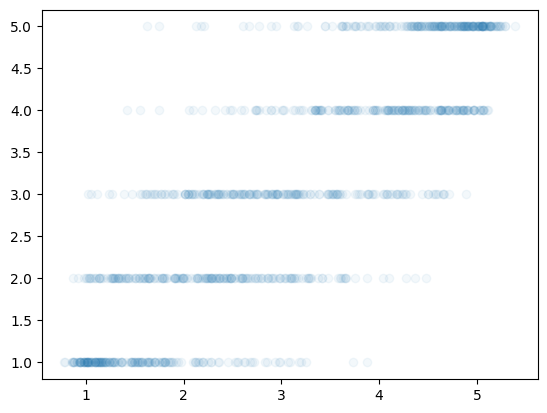

In [73]:
plt.scatter(preds_output.predictions+1, preds_output.label_ids+1, alpha=0.05)